In [4]:
import gym
from gym import spaces
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import os
import numpy as np

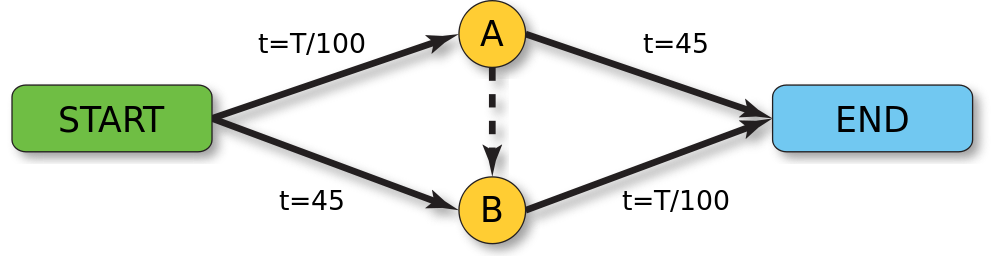

# Actions

In [5]:
import itertools

N = 400

#actions = {seq for seq in itertools.product("01", repeat=N)} (# too expensive)
from math import factorial

print(factorial(N)/factorial(N-2))

159600.0


In [6]:
from random import random

actions_sample = ['A' if random()>0.5 else 'B' for x in range(N)]
print(actions_sample[:10])

T = sum([a=='A' for a in actions_sample])
print(T)

['B', 'B', 'A', 'B', 'A', 'A', 'B', 'A', 'B', 'A']
199


# Rewards

In [7]:
rewards = [T/100 if a=='A' else 45 for a in actions_sample]
print(rewards[:10])

[45, 45, 1.99, 45, 1.99, 1.99, 45, 1.99, 45, 1.99]


# States

In [8]:
states = {}
states['Start'] =  {'S': N, 'A': 0, 'B': 0, 'E': 0}

for t in range(N+1):
    states[str(t)] = {'S': 0, 'A': t, 'B': N - t, 'E': 0}

states['End'] = {'S': 0, 'A': 0, 'B': 0, 'E': N}

In [9]:
states[str(T)]

{'S': 0, 'A': 199, 'B': 201, 'E': 0}

In [10]:
states = {}
for i in range(N+1):
    for step in {0, 1}:
        for position in {'S', 'A', 'B'}:
            states[(position, step, i, N-i)] = 0.0

In [11]:
states

{('B', 0, 0, 400): 0.0,
 ('A', 0, 0, 400): 0.0,
 ('S', 0, 0, 400): 0.0,
 ('B', 1, 0, 400): 0.0,
 ('A', 1, 0, 400): 0.0,
 ('S', 1, 0, 400): 0.0,
 ('B', 0, 1, 399): 0.0,
 ('A', 0, 1, 399): 0.0,
 ('S', 0, 1, 399): 0.0,
 ('B', 1, 1, 399): 0.0,
 ('A', 1, 1, 399): 0.0,
 ('S', 1, 1, 399): 0.0,
 ('B', 0, 2, 398): 0.0,
 ('A', 0, 2, 398): 0.0,
 ('S', 0, 2, 398): 0.0,
 ('B', 1, 2, 398): 0.0,
 ('A', 1, 2, 398): 0.0,
 ('S', 1, 2, 398): 0.0,
 ('B', 0, 3, 397): 0.0,
 ('A', 0, 3, 397): 0.0,
 ('S', 0, 3, 397): 0.0,
 ('B', 1, 3, 397): 0.0,
 ('A', 1, 3, 397): 0.0,
 ('S', 1, 3, 397): 0.0,
 ('B', 0, 4, 396): 0.0,
 ('A', 0, 4, 396): 0.0,
 ('S', 0, 4, 396): 0.0,
 ('B', 1, 4, 396): 0.0,
 ('A', 1, 4, 396): 0.0,
 ('S', 1, 4, 396): 0.0,
 ('B', 0, 5, 395): 0.0,
 ('A', 0, 5, 395): 0.0,
 ('S', 0, 5, 395): 0.0,
 ('B', 1, 5, 395): 0.0,
 ('A', 1, 5, 395): 0.0,
 ('S', 1, 5, 395): 0.0,
 ('B', 0, 6, 394): 0.0,
 ('A', 0, 6, 394): 0.0,
 ('S', 0, 6, 394): 0.0,
 ('B', 1, 6, 394): 0.0,
 ('A', 1, 6, 394): 0.0,
 ('S', 1, 6, 394

# Environment

In [113]:
class BraessParadoxEnv(gym.Env):
    
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}

    def __init__(self):
        
        super(BraessParadoxEnv, self).__init__()
        
        self.n_agents = 400
        
    def reset(self):
        
        self.state = {'step': 0}
        
        for i in range(self.n_agents):
            
            self.state[i] = 'S'
            
        self.done = False
        
        return self.state
    
    def step(self, actions):
        
        info = {}
        for i in range(self.n_agents):
            
            self.state[i] = actions[i]
            
        if self.state['step'] == 0:
            
            self.state['step'] = 1
            T =  sum([a=='A' for a in actions])
            rewards = [ -T/10 if a=='A' else -4.5 for a in actions]
            
        else:
            
            T = sum([a=='B' for a in actions])
            rewards = [ -4.5 if a=='A' else -T/10 for a in actions]
            self.done = True
            
        return self.state, rewards, self.done, info

    
    def render(self, mode='human', close=False):
        
        # Render the environment to the screen
        pass



In [63]:
env = BraessParadoxEnv()
new_state = env.reset()

new_state['step'], new_state[0]

(0, 'S')

In [64]:
sample_actions = ['A' if random() > 0.5 else 'B' for x in range(4000)]

new_state, rewards, done, info = env.step(sample_actions)

In [65]:
sample_actions[0], new_state['step'], new_state[0], rewards[0], done

('B', 1, 'B', -45, False)

In [66]:
sample_actions = ['B' if (a == 'A') and (random() > 0.5) else a for a in sample_actions]

new_state, rewards, done, info = env.step(sample_actions)

In [67]:
sample_actions[0], new_state['step'], new_state[0], rewards[0], done

('B', 1, 'B', -30.21, True)

In [95]:
class QAgent():
    
    def __init__(self, id_agent, lr, gamma, n_agents, eps_start, eps_end, eps_dec):
        
        self.id_agent = id_agent
        self.lr = lr
        self.gamma = gamma
        self.n_agents = n_agents
        self.epsilon = eps_start
        self.eps_min = eps_end
        self.eps_dec = eps_dec

        self.Q = {}

        self.init_Q()

    def init_Q(self):
        
        for step in {0, 1}:
            for position in {'S', 'A', 'B'}:
                for action in {'A', 'B'}:
                    self.Q[(position, step, action)] = 0.0

    def choose_action(self, state):
        
        position = state[self.id_agent]
        step = state['step']
        

        Q_ = np.array([self.Q[(position, step, a)] for a in ['A', 'B']])
        explore = random() < self.epsilon
        
        if step == 0:
            
            if explore:
                action = np.random.choice(['A', 'B'])
            else:
                action = ['A', 'B'][int(np.argmax(Q_))]
            
        else:
            if state[self.id_agent] == 'A':
                if explore:
                    action = np.random.choice(['A', 'B'])
                    
                else:
                    action = ['A', 'B'][int(np.argmax(Q_))]
            else:
                action = state[self.id_agent]
            
        return action

    def decrement_epsilon(self):
        self.epsilon = self.epsilon*self.eps_dec if self.epsilon>self.eps_min\
                       else self.eps_min

    def learn(self, state, action, reward, state_):
        
        position = state[self.id_agent]
        step = state['step']

        actions = np.array([self.Q[(position, step, a)] for a in ['A', 'B']])
        
        a_max = ['A', 'B'][int(np.argmax(actions))]

        self.Q[(position, step, action)] += self.lr*(reward +
                                        self.gamma*self.Q[(position, step, a_max)] -
                                        self.Q[(position, step, action)])
        self.decrement_epsilon()

In [70]:
params = {'lr': 0.005, 
          'gamma': 0.999, 
          'eps_start': 1.0, 
          'eps_end': 0.001,
          'eps_dec': 0.995, 
          'n_agents': 4000}

agent = QAgent(**params, id_agent=1)

In [71]:
env = BraessParadoxEnv()
n_agents = env.n_agents
new_state = env.reset()

new_state['step'], new_state[0]

(0, 'S')

In [74]:
params = {'lr': 0.005, 
          'gamma': 0.999, 
          'eps_start': 1.0, 
          'eps_end': 0.001,
          'eps_dec': 0.995, 
          'n_agents': 4000}

In [75]:
agents = [QAgent(**params, id_agent=i) for i in tqdm(range(n_agents))]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [76]:
agents[0].choose_action(new_state)

'B'

In [77]:
actions = [agents[i].choose_action(new_state) for i in tqdm(range(env.n_agents))]
actions[0]

  0%|          | 0/4000 [00:00<?, ?it/s]

'A'

In [78]:
new_state, rewards, done, info = env.step(actions)

In [79]:
new_state[0], rewards[0], done

('A', -20.33, False)

In [80]:
actions = [agents[i].choose_action(new_state) for i in tqdm(range(env.n_agents))]
actions[0]

  0%|          | 0/4000 [00:00<?, ?it/s]

'B'

In [81]:
state = new_state
new_state, rewards, done, info = env.step(actions)

In [82]:
new_state[0]

'B'

In [83]:
state

{'step': 1,
 0: 'B',
 1: 'A',
 2: 'B',
 3: 'B',
 4: 'A',
 5: 'B',
 6: 'B',
 7: 'A',
 8: 'B',
 9: 'B',
 10: 'A',
 11: 'B',
 12: 'B',
 13: 'B',
 14: 'A',
 15: 'B',
 16: 'B',
 17: 'B',
 18: 'B',
 19: 'B',
 20: 'B',
 21: 'B',
 22: 'A',
 23: 'B',
 24: 'B',
 25: 'B',
 26: 'B',
 27: 'B',
 28: 'A',
 29: 'B',
 30: 'A',
 31: 'B',
 32: 'B',
 33: 'B',
 34: 'B',
 35: 'B',
 36: 'B',
 37: 'B',
 38: 'B',
 39: 'B',
 40: 'B',
 41: 'A',
 42: 'B',
 43: 'B',
 44: 'B',
 45: 'A',
 46: 'B',
 47: 'B',
 48: 'A',
 49: 'B',
 50: 'B',
 51: 'B',
 52: 'B',
 53: 'B',
 54: 'B',
 55: 'B',
 56: 'A',
 57: 'B',
 58: 'B',
 59: 'B',
 60: 'B',
 61: 'B',
 62: 'B',
 63: 'B',
 64: 'B',
 65: 'B',
 66: 'B',
 67: 'A',
 68: 'B',
 69: 'A',
 70: 'B',
 71: 'B',
 72: 'B',
 73: 'B',
 74: 'B',
 75: 'B',
 76: 'B',
 77: 'B',
 78: 'B',
 79: 'B',
 80: 'B',
 81: 'B',
 82: 'B',
 83: 'B',
 84: 'B',
 85: 'B',
 86: 'A',
 87: 'B',
 88: 'B',
 89: 'B',
 90: 'A',
 91: 'B',
 92: 'B',
 93: 'B',
 94: 'A',
 95: 'B',
 96: 'B',
 97: 'B',
 98: 'A',
 99: 'B'

In [84]:
agents[0].Q

{('B', 0, 'B'): 0.0,
 ('B', 0, 'A'): 0.0,
 ('A', 0, 'B'): 0.0,
 ('A', 0, 'A'): 0.0,
 ('S', 0, 'B'): 0.0,
 ('S', 0, 'A'): 0.0,
 ('B', 1, 'B'): 0.0,
 ('B', 1, 'A'): 0.0,
 ('A', 1, 'B'): 0.0,
 ('A', 1, 'A'): 0.0,
 ('S', 1, 'B'): 0.0,
 ('S', 1, 'A'): 0.0}

In [85]:
from random import random

In [86]:
agents[0].learn(state, actions[0], rewards[0], new_state)

In [87]:
import pprint
pp = pprint.PrettyPrinter()

In [136]:
env = BraessParadoxEnv()
env.n_agents = 400
n_agents = env.n_agents

params = {'lr': 0.005, 
          'gamma': 0.999, 
          'eps_start': 1.0, 
          'eps_end': 0.001,
          'eps_dec': 0.995, 
          'n_agents': n_agents}

agents = [QAgent(**params, id_agent=i) for i in tqdm(range(env.n_agents))]

scores = defaultdict(list)
win_pct_list = []
n_episodes = 1000
cooperations = []
qvalues = []
actions_list = []

for i_episode in tqdm(range(n_episodes)):
    
    
    actions_episode = []
    done = False
    state = env.reset()
    scores_episode = defaultdict(int)
    
    while not done:
        
        actions = [agents[i].choose_action(state) for i in range(env.n_agents)]
        new_state, rewards, done, info = env.step(actions)
        
        # Utilitarian Social Welfare
        rewards = [sum(rewards)/n_agents]*n_agents
        
        # Rawls Social Welfare
        #rewards = [min(rewards)]*n_agents
        
        for id_agent in range(n_agents):
            agents[id_agent].learn(state, actions[id_agent], rewards[id_agent], new_state)
            scores_episode[id_agent] += rewards[id_agent]
            
        state = new_state
        actions_episode.append(actions)
        
    actions_list.append(actions_episode)
    
    qvalues.append(agents[0].Q)
    
    for id_agent in range(n_agents):
        scores[id_agent].append(scores_episode[id_agent])
    
    if i_episode % 100 == 0:
        
        mean_scores = [np.mean(scores[i][-100:]) for i in range(n_agents)]
        
        print('episode ', i_episode, 
              '\n Mean Reward Agent 1 %.2f' % mean_scores[0],
              '\n epsilon %.2f \n' % agents[0].epsilon)
    
        #print('Q Values:')
        #pp.pprint(agents[0].Q)
        print('-'*100+'\n')

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

episode  0 
 Mean Reward Agent 1 -34.96 
 epsilon 0.99 

----------------------------------------------------------------------------------------------------

episode  100 
 Mean Reward Agent 1 -46.80 
 epsilon 0.36 

----------------------------------------------------------------------------------------------------

episode  200 
 Mean Reward Agent 1 -64.75 
 epsilon 0.13 

----------------------------------------------------------------------------------------------------

episode  300 
 Mean Reward Agent 1 -74.05 
 epsilon 0.05 

----------------------------------------------------------------------------------------------------

episode  400 
 Mean Reward Agent 1 -77.72 
 epsilon 0.02 

----------------------------------------------------------------------------------------------------

episode  500 
 Mean Reward Agent 1 -79.15 
 epsilon 0.01 

----------------------------------------------------------------------------------------------------

episode  600 
 Mean Reward Agent 1 -

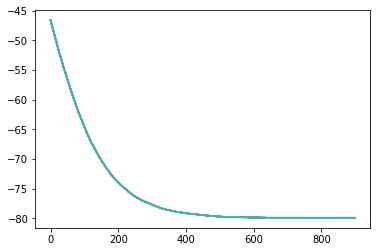

In [137]:
scores_utilitarian = scores


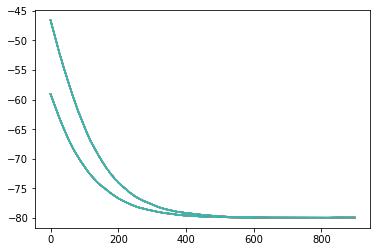

In [138]:
for x in range(10):
    plt.plot([np.mean(scores_rawls[x][i-100:i]) for i in range(100, len((scores_rawls[x])))])
    

for x in range(10):
    plt.plot([np.mean(scores_utilitarian[x][i-100:i]) for i in range(100, len((scores_utilitarian[x])))])

plt.show()

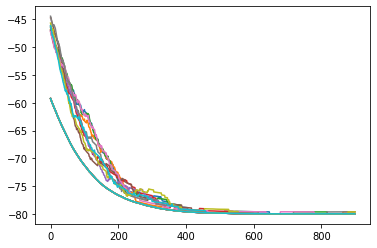

In [130]:
for x in range(10):
    plt.plot([np.mean(scores[x][i-100:i]) for i in range(100, len((scores[x])))])

for x in range(10):
    plt.plot([np.mean(scores_rawls[x][i-100:i]) for i in range(100, len((scores_rawls[x])))])
plt.show()

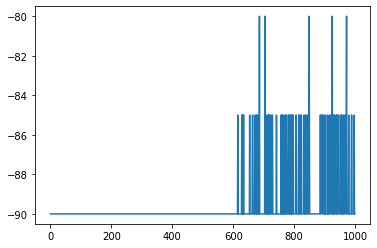

In [104]:
plt.plot(scores[0])

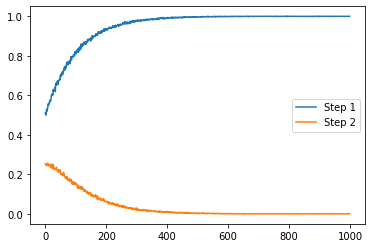

In [108]:
plt.plot([[sum([a == 'A' for a in step])/4000 for step in episode][0] for episode in actions_list], label='Step 1')
plt.plot([[sum([a == 'A' for a in step])/4000 for step in episode][1] for episode in actions_list], label='Step 2')
plt.legend()

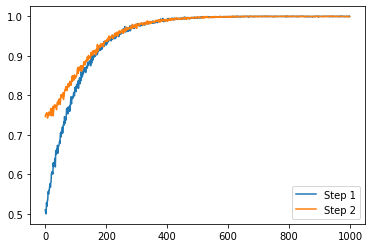

In [112]:
plt.plot([[sum([a == 'A' for a in step])/4000 for step in episode][0] for episode in actions_list], label='Step 1')
plt.plot([[sum([a == 'B' for a in step])/4000 for step in episode][1] for episode in actions_list], label='Step 2')
plt.legend()

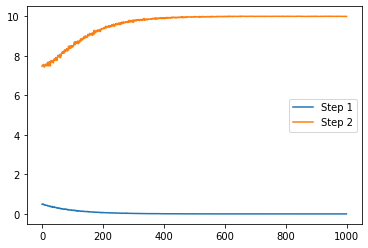

In [110]:
plt.plot([[sum([a == 'B' for a in step])/4000 for step in episode][0] for episode in actions_list], label='Step 1')
plt.plot([[sum([a == 'B' for a in step])/400 for step in episode][1] for episode in actions_list], label='Step 2')
plt.legend()